In [1]:
%load_ext sql

In [2]:
%sql sqlite:///Northwind.db

'Connected: @Northwind.db'

In [3]:
from sqlalchemy import create_engine

# Create an engine to the database
engine = create_engine('sqlite:///Northwind.db')

# Connect to the engine
with engine.connect() as connection:
    # Execute the correct SQL command to list tables
    result = connection.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = result.fetchall()

    # Print the tables
    for table in tables:
        print(table[0])

Categories
Customers
Region
Shippers
Suppliers
Employees
EmployeeTerritories
OrderDetails
Orders
Territories
Products


### Key Tables

## Total Sales Per Month

In [5]:
%%sql

SELECT 
    STRFTIME('%m', OrderDate) AS OrderMonth, 
    COUNT(o.OrderID) AS Total_orders, 
    SUM(od.Quantity * od.UnitPrice) AS Total_sales
FROM 
    Orders o
JOIN
    OrderDetails od
ON
    od.OrderID = o.OrderID
GROUP BY 
    OrderMonth
ORDER BY 
    Total_sales DESC;

 * sqlite:///Northwind.db
Done.


OrderMonth,Total_orders,Total_sales
04,261,190329.95
01,237,167547.52
03,255,149805.35
02,201,145769.15
12,195,128429.66
10,179,111532.1
11,155,95617.36
09,152,87369.02
07,136,85657.03
05,155,76722.36


## Total Sales Per Year

In [6]:
%%sql

SELECT 
    STRFTIME('%Y', OrderDate) AS OrderYear, 
    COUNT(o.OrderID) AS Total_orders, 
    SUM(Quantity * UnitPrice) AS Total_sales
FROM 
    Orders o
JOIN
    OrderDetails od
ON
    od.OrderID = o.OrderID
GROUP BY 
    OrderYear
ORDER BY 
    Total_sales;

 * sqlite:///Northwind.db
Done.


OrderYear,Total_orders,Total_sales
1996,405,226298.5
1998,691,469771.34
1997,1059,658388.75


## Sales By Product Category

In [7]:
%%sql

SELECT
    CategoryName,
    COUNT(o.OrderID) AS Total_orders, 
    SUM(od.Quantity * od.UnitPrice) AS Total_sales
FROM
    Orders o
JOIN
    OrderDetails od
ON
    o.OrderID = od.OrderID
JOIN
    Products p
ON
    od.ProductID = p.ProductID
JOIN
    Categories c
ON
    c.CategoryID = p.CategoryID
GROUP BY
    CategoryName
ORDER BY
    Total_sales DESC;

 * sqlite:///Northwind.db
Done.


CategoryName,Total_orders,Total_sales
Beverages,404,286526.95
Dairy Products,366,251330.5
Meat/Poultry,173,178188.80000000002
Confections,334,177099.1
Seafood,330,141623.09
Condiments,216,113694.75
Produce,136,105268.6
Grains/Cereals,196,100726.8


## Sales By Region

In [8]:
%%sql

SELECT
    Region,
    COUNT(o.OrderID) AS Total_orders, 
    SUM(od.Quantity * od.UnitPrice) AS Total_sales
FROM
    Orders o
JOIN
    OrderDetails od
ON
    o.OrderID = od.OrderID
JOIN
    Customers c
ON
    c.CustomerID = o.CustomerID
GROUP BY
    Region
ORDER BY
    Total_sales DESC;

 * sqlite:///Northwind.db
Done.


Region,Total_orders,Total_sales
None,1329,796310.45
ID,116,115673.39
SP,120,60969.3
Co. Cork,55,57317.39
RJ,83,53999.18
NM,71,52245.9
Qubec,32,32203.9
WA,51,31001.65
OR,52,30393.93
Tchira,45,23611.58


# Data Preprocessing

### Handling missing values

In [9]:
import sqlite3
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from statsmodels.tsa.arima.model import ARIMA


conn = sqlite3.connect("Northwind.db")  

In [10]:
orders =  pd.read_sql("SELECT * FROM Orders", conn)             
order_details =  pd.read_sql("SELECT * FROM OrderDetails", conn)
products =  pd.read_sql("SELECT * FROM Products", conn)
categories = pd.read_sql('SELECT * FROM Categories', conn)
sales = orders.merge(order_details, on='OrderID', how='inner') \
              .merge(products[['ProductID', 'ProductName']], on='ProductID', how='left')

In [11]:
print(sales.isnull().sum())

OrderID              0
CustomerID           0
EmployeeID           0
OrderDate            0
RequiredDate         0
ShippedDate         73
ShipVia              0
Freight              0
ShipName             0
ShipAddress          0
ShipCity             0
ShipRegion        1299
ShipPostalCode      55
ShipCountry          0
ProductID            0
UnitPrice            0
Quantity             0
Discount             0
ProductName          0
dtype: int64


In [12]:
sales['ShippedDate'] = sales['ShippedDate'].fillna(0)
sales['ShipRegion'] = sales['ShipRegion'].fillna('Unknown Region')
sales['ShipPostalCode'] = sales['ShipPostalCode'].fillna(00000)

In [13]:
print(sales.isnull().sum())

OrderID           0
CustomerID        0
EmployeeID        0
OrderDate         0
RequiredDate      0
ShippedDate       0
ShipVia           0
Freight           0
ShipName          0
ShipAddress       0
ShipCity          0
ShipRegion        0
ShipPostalCode    0
ShipCountry       0
ProductID         0
UnitPrice         0
Quantity          0
Discount          0
ProductName       0
dtype: int64


### Convert order dates into time-series format

In [14]:
orders
print(orders['OrderDate'].head())

0    1996-07-04 00:00:00
1    1996-07-05 00:00:00
2    1996-07-08 00:00:00
3    1996-07-08 00:00:00
4    1996-07-09 00:00:00
Name: OrderDate, dtype: object


In [15]:
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
orders['OrderDate']

0     1996-07-04
1     1996-07-05
2     1996-07-08
3     1996-07-08
4     1996-07-09
         ...    
825   1998-05-05
826   1998-05-06
827   1998-05-06
828   1998-05-06
829   1998-05-06
Name: OrderDate, Length: 830, dtype: datetime64[ns]

### Aggregate sales into monthly, quarterly, or yearly totals for forecasting

In [28]:
df = pd.merge(orders, order_details, on='OrderID')
df = pd.merge(df, products, on='ProductID')
df = pd.merge(df, categories, on='CategoryID')

df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['Sales'] = df['Quantity'] * df['UnitPrice_x']  * (1 - df['Discount'])

In [29]:
monthly_sales = df.groupby(pd.Grouper(key='OrderDate', freq='ME'))['Sales'].sum().reset_index()

monthly_sales.columns = ['Month', 'TotalSales']

monthly_sales.set_index('Month', inplace=True)

print(monthly_sales.head())

            TotalSales
Month                 
1996-07-31     30192.1
1996-08-31     26609.4
1996-09-30     27636.0
1996-10-31     41203.6
1996-11-30     49704.0


In [30]:
quarterly_sales = df.groupby(pd.Grouper(key='OrderDate', freq='QE'))['Sales'].sum().reset_index()

quarterly_sales.columns = ['Quarter', 'TotalSales']

quarterly_sales.set_index('Quarter', inplace=True)

print(quarterly_sales.head())

            TotalSales
Quarter               
1996-09-30    84437.50
1996-12-31   141861.00
1997-03-31   147879.90
1997-06-30   151611.09
1997-09-30   165179.64


In [31]:
yearly_sales = df.groupby(pd.Grouper(key='OrderDate', freq='YE'))['Sales'].sum().reset_index()

yearly_sales.columns = ['Year', 'TotalSales']

yearly_sales.set_index('Year', inplace=True)

print(yearly_sales.head())

            TotalSales
Year                  
1996-12-31   226298.50
1997-12-31   658388.75
1998-12-31   469771.34


### Check for seasonality, trends, and anomalies.

Seasonality is a repeating short term cycle in the time series

Trend is the overall direction of a time series, which may show a consisteny increase, decrease, or a mix of both overtime

Residual(Noise) is a random variation in the series. Found from subtracting trend and seasonality components from original time series

Every time series must have noise

### Seasonality Trends, and Residue

<Axes: title={'center': 'Northwind Quarterly Sales'}, xlabel='Quarter'>

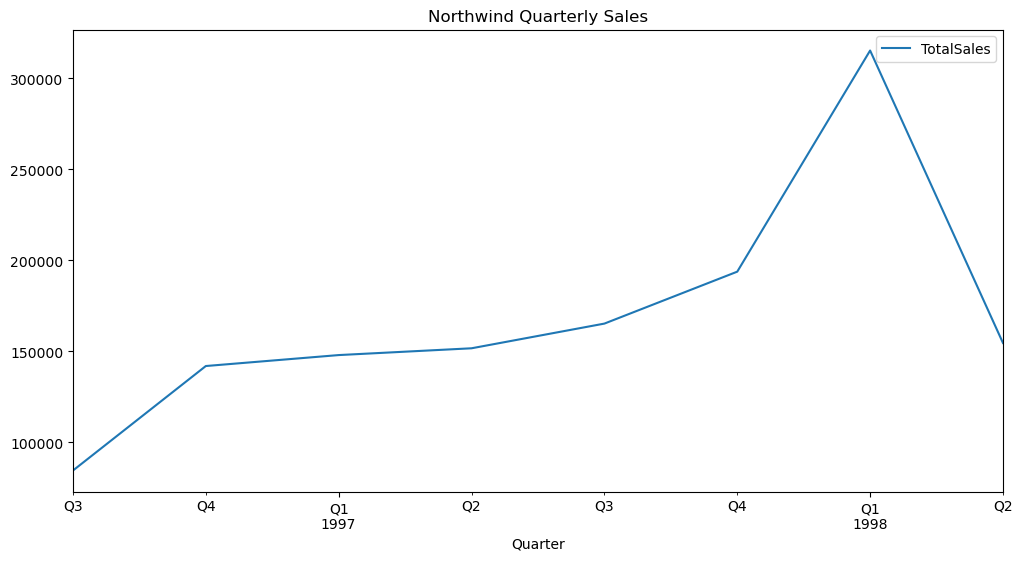

In [32]:
quarterly_sales.plot(title = 'Northwind Quarterly Sales', figsize=(12,6))

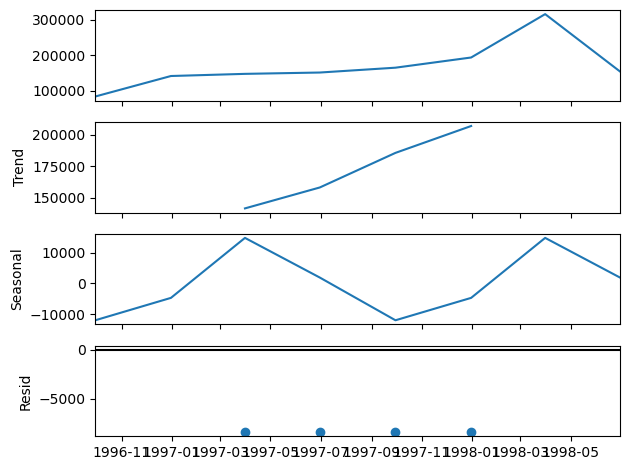

In [33]:
decomp = seasonal_decompose(quarterly_sales, model='additive', period=4)
decomp.plot()
plt.tight_layout()
plt.show()

In [37]:
result = adfuller(quarterly_sales)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: 4.133718646997694
p-value: 1.0


In [38]:
quarterly_sales_diff = quarterly_sales['TotalSales'].diff().dropna()

In [40]:
result = adfuller(quarterly_sales_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("Series is stationary → No trend")
else:
    print("Series is non-stationary → Trend likely present")

ADF Statistic: -3.893028675707955
p-value: 0.0020867554647614256
Series is stationary → No trend


### Anomaly Detection

Anomaly detection is identifying data points or patterns that deviate significantly from the expected or normal behavior within a time series dataset 

In [41]:
residuals = decomp.resid.dropna()
threshold = 2 * residuals.std()

anomalies = residuals[abs(residuals) > threshold]

print("Anomaly:\n", anomalies)

Anomaly:
 Quarter
1997-03-31   -8396.602813
1997-06-30   -8396.602813
1997-09-30   -8396.602813
1997-12-31   -8396.602813
Name: resid, dtype: float64


## Model Building: Time Series Forecasting 

Time Series Forecasting is a statistical technique used to predict future values of a time series based on past observations. In simpler terms, it's like looking into the future of data points plotted over time. By analyzing patterns and trends in historical data, Time Series Forecasting helps make informed predictions about what may happen next, assisting in decision-making and planning for the future.

### Moving Average

In [42]:
quarterly_sales['Moving_Average'] = quarterly_sales['TotalSales'].rolling(window=4).mean()

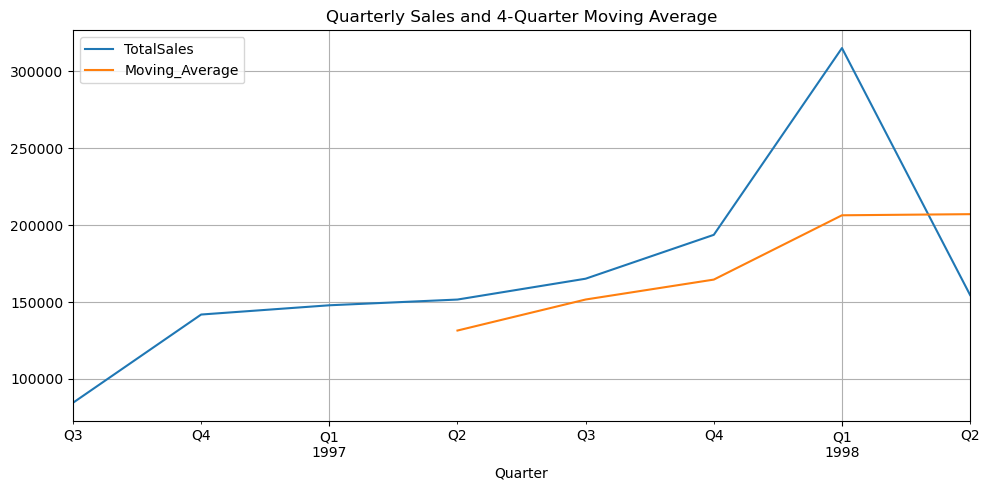

In [43]:
quarterly_sales[['TotalSales', 'Moving_Average']].plot(figsize=(10, 5), title='Quarterly Sales and 4-Quarter Moving Average')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Train and validate the model

In [44]:
train = quarterly_sales.iloc[:-2].copy()
valid = quarterly_sales.iloc[-3:].copy()

# Calculate SMA on the training test 
train['Moving_Average'] = train['TotalSales'].rolling(window=4).mean()

# Forecast 4 quarters with the last available sma
sma = train['Moving_Average'].dropna().iloc[-1]
sma_forecast = pd.Series([sma] * 3, index=valid.index)

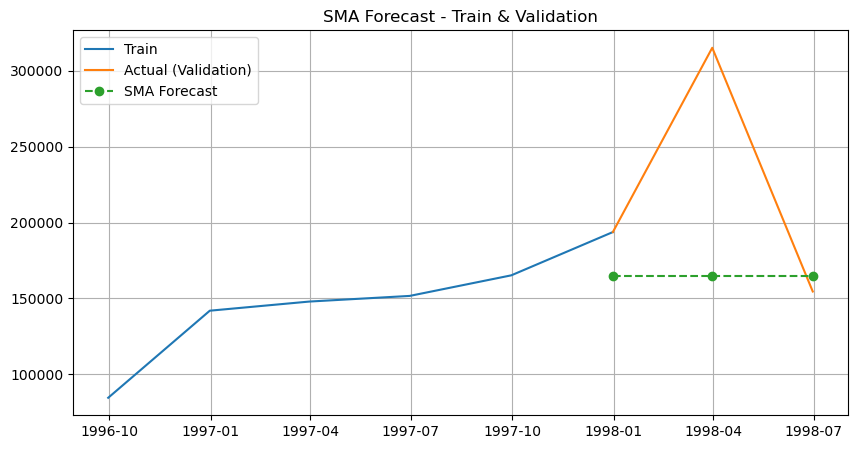

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(train['TotalSales'], label='Train')
plt.plot(valid['TotalSales'], label='Actual (Validation)')
plt.plot(sma_forecast, label='SMA Forecast', linestyle='--', marker='o')
plt.legend()
plt.title('SMA Forecast - Train & Validation')
plt.grid(True)
plt.show()

#### Model Evaluation

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(valid['TotalSales'], sma_forecast)
rmse = np.sqrt(mean_squared_error(valid['TotalSales'], sma_forecast))
mape = (abs(valid['TotalSales'] - sma_forecast) / valid['TotalSales']).mean() * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  63277.94
RMSE: 88775.54
MAPE: 23.11%


### ARIMA

ARIMA(Auto-Regressive Model Integrated Moving average) is a general class of statistical models for time series analysis forecasting

ARIMA uses a time series past values and/or forecast error to predict its future values 

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

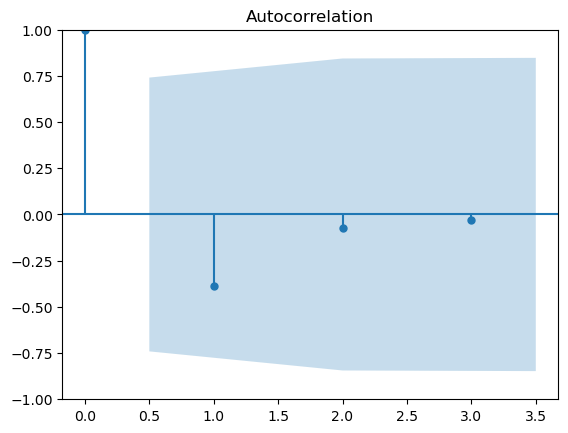

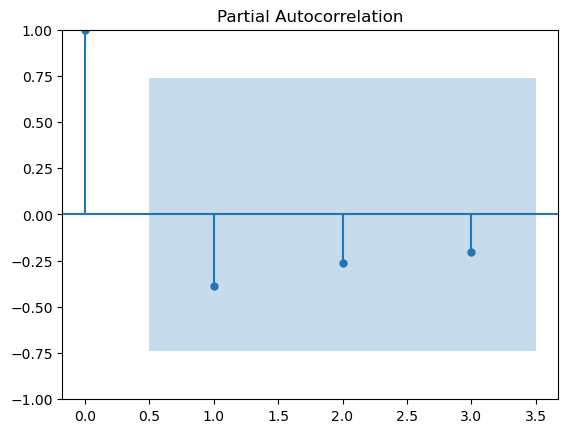

In [48]:
plot_acf(quarterly_sales_diff)
plot_pacf(quarterly_sales_diff)
plt.show()

In [63]:
from statsmodels.tsa.arima.model import ARIMA

#train and validate the model
train = quarterly_sales.iloc[:-1].copy()
valid = quarterly_sales.iloc[-1:].copy()

quarterly_sales = quarterly_sales.asfreq('QE') 
model = ARIMA(train['TotalSales'], order=(0, 0, 0))
results = model.fit()

forecast = results.forecast(steps=1)
forecast.index = valid.index  

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             TotalSales   No. Observations:                    7
Model:                          ARIMA   Log Likelihood                 -91.438
Date:                Fri, 27 Jun 2025   AIC                            186.877
Time:                        03:24:57   BIC                            186.768
Sample:                    09-30-1996   HQIC                           185.540
                         - 03-31-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.714e+05   1.78e+05      0.964      0.335   -1.77e+05     5.2e+05
sigma2      3.061e+10   2.65e+10      1.155      0.248   -2.13e+10    8.25e+10
Ljung-Box (L1) (Q):                   0.54   Jarque-

#### Model Evaluation

In [50]:
# Actual vs Forecast
actual = valid['TotalSales']
predicted = forecast

# Compute metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = (abs(actual - predicted) / actual).mean() * 100

# Print results
print(f"📊 ARIMA Model Evaluation:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

📊 ARIMA Model Evaluation:
MAE:  16889.26
RMSE: 16889.26
MAPE: 10.93%


### Exponential Smoothing

Time series methods follow the assumption that a forecast is a linear sum of all past observations or delays. Exponential smoothing gives more weight to the most recent observations and reduces exponentially as the distance from the observations rises, with the premise that the future will be similar to the recent past. The word "exponential smoothing" refers to the fact that each demand observation is assigned an exponentially diminishing weight.

- This technique captures the general pattern and can be expanded to include trends and seasonal variations, allowing for precise time series forecasts using past data.
- This method gives a bit of erroneous long-term forecasts.
- It works well with the technique of smoothing when the parameters of the time series change gradually over time.


### Types of exponential smoothing

1. Single or simple exponential smoothing
2. Double exponential smoothing
3. Holt-Winters’ exponential smoothing

In [51]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

quarterly_sales.index.freq = quarterly_sales.index.inferred_freq

train = quarterly_sales.iloc[:-3]
valid = quarterly_sales.iloc[-3:]

model = SimpleExpSmoothing(train['TotalSales']).fit(smoothing_level=0.6, optimized=False)
forecast = model.forecast(steps=3)
forecast.index = valid.index  
  
forecast = model.forecast(3)
print(forecast)

1997-12-31    157299.9784
1998-03-31    157299.9784
1998-06-30    157299.9784
Freq: QE-DEC, dtype: float64


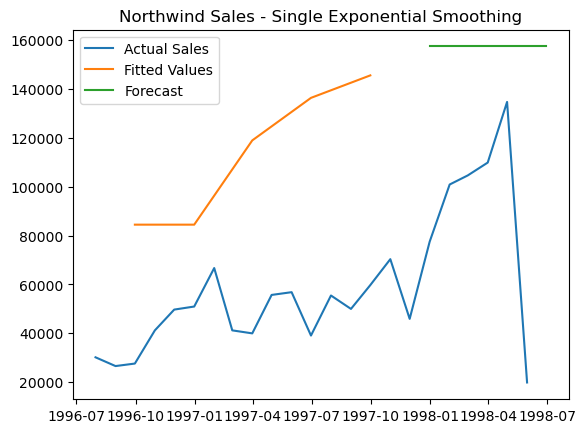

In [52]:
plt.plot( monthly_sales, label='Actual Sales')
plt.plot( model.fittedvalues, label='Fitted Values')
plt.plot(forecast, label='Forecast')
plt.title('Northwind Sales - Single Exponential Smoothing')
plt.legend()
plt.show()

#### Model Evaluation For Exponential Smoothing

In [53]:
mae = mean_absolute_error(valid['TotalSales'], forecast)
rmse = np.sqrt(mean_squared_error(valid['TotalSales'], forecast))
mape = (abs(valid['TotalSales'] - forecast) / valid['TotalSales']).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 65710.35
RMSE: 93594.30
MAPE: 23.56%


### Facebook Prophet

In [54]:
df_prophet = quarterly_sales.reset_index()[['Quarter', 'TotalSales']]
df_prophet.columns = ['ds', 'y']

In [55]:
from prophet import Prophet

train = df_prophet.iloc[:-4].copy()
valid = df_prophet.iloc[-4:].copy()

model = Prophet()
model.fit(train)

02:21:23 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future = model.make_future_dataframe(periods=4, freq='QE')
forecast = model.predict(future)

In [57]:
forecast_valid = forecast.set_index('ds').loc[valid['ds']]
predicted = forecast_valid['yhat'].values
actual = valid['y'].values

C:\Users\Itiayo Gbadebo\anaconda3\envs\python\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Itiayo Gbadebo\anaconda3\envs\python\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


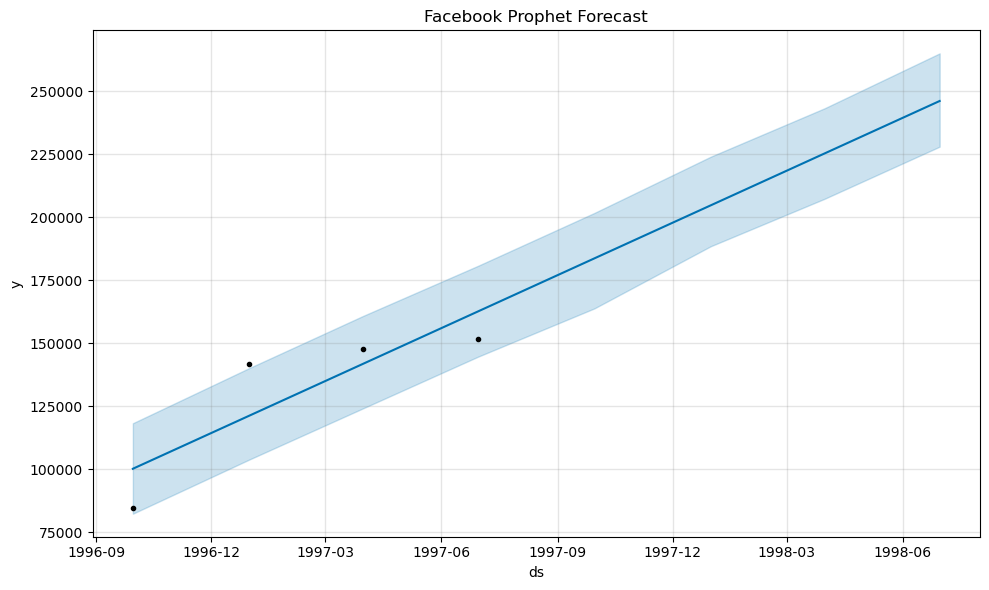

In [58]:
# Full forecast plot
model.plot(forecast)
plt.title("Facebook Prophet Forecast")
plt.grid(True)
plt.tight_layout()
plt.show()

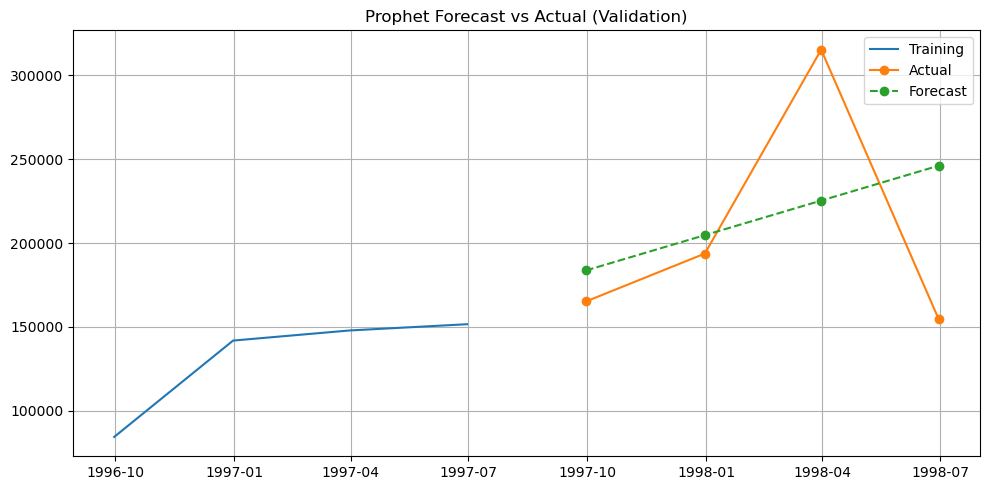

In [59]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training')
plt.plot(valid['ds'], actual, label='Actual', marker='o')
plt.plot(valid['ds'], predicted, label='Forecast', marker='o', linestyle='--')
plt.title('Prophet Forecast vs Actual (Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model Evaluation

In [60]:
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = (abs(actual - predicted) / actual).mean() * 100

print("📊 Prophet Forecast Evaluation on Validation Set:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

📊 Prophet Forecast Evaluation on Validation Set:
MAE:  52750.28
RMSE: 65078.08
MAPE: 26.17%


The most accurate model for forecasting future sales is Auto-regressive integrated moving average(ARIMA)

### Business Insights And Recommendations

In [72]:
%%sql
SELECT 
    c.CategoryName,
    SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS TotalSales
FROM 
    OrderDetails od
JOIN 
    Products p 
ON 
    od.ProductID = p.ProductID
JOIN 
    Categories c 
ON 
    p.CategoryID = c.CategoryID
GROUP BY 
    c.CategoryName
ORDER BY 
    TotalSales DESC;

 * sqlite:///Northwind.db
Done.


CategoryName,TotalSales
Beverages,286526.95
Dairy Products,251330.5
Meat/Poultry,178188.80000000002
Confections,177099.1
Seafood,141623.09
Condiments,113694.75
Produce,105268.6
Grains/Cereals,100726.8


The highest performing product category is beverage and dairy products

### Sales Trend

In [81]:
%%sql
SELECT 
    STRFTIME('%Y-%m',o.OrderDate) AS OrderMonth,
    c.CategoryName,
    SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) AS MonthlySales
FROM 
    Orders o
JOIN 
    OrderDetails od 
ON 
    o.OrderID = od.OrderID
JOIN 
    Products p 
ON 
    od.ProductID = p.ProductID
JOIN 
    Categories c 
ON 
    p.CategoryID = c.CategoryID
GROUP BY 
    OrderMonth, c.CategoryName
ORDER BY 
    OrderMonth, MonthlySales DESC;

 * sqlite:///Northwind.db
Done.


OrderMonth,CategoryName,MonthlySales
1996-07,Dairy Products,7385.6
1996-07,Confections,6261.0
1996-07,Produce,4163.4
1996-07,Beverages,3438.0
1996-07,Seafood,2770.5
1996-07,Meat/Poultry,2722.2
1996-07,Condiments,2177.8
1996-07,Grains/Cereals,1273.6
1996-08,Confections,5224.8
1996-08,Beverages,5036.4


In [82]:
%%sql
SELECT 
    STRFTIME('%Y', o.OrderDate) AS OrderYear,
    CASE 
        WHEN STRFTIME('%m', o.OrderDate) IN ('01', '02', '03') THEN 'Q1'
        WHEN STRFTIME('%m', o.OrderDate) IN ('04', '05', '06') THEN 'Q2'
        WHEN STRFTIME('%m', o.OrderDate) IN ('07', '08', '09') THEN 'Q3'
        WHEN STRFTIME('%m', o.OrderDate) IN ('10', '11', '12') THEN 'Q4'
    END AS OrderQuarter,
    c.CategoryName,
    ROUND(SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)), 2) AS QuarterlySales
FROM 
    Orders o
JOIN 
    OrderDetails od 
ON 
    o.OrderID = od.OrderID
JOIN 
    Products p 
ON 
    od.ProductID = p.ProductID
JOIN 
    Categories c 
ON 
    p.CategoryID = c.CategoryID
GROUP BY 
    OrderYear, OrderQuarter, c.CategoryName
ORDER BY 
    OrderYear, OrderQuarter, QuarterlySales DESC;

 * sqlite:///Northwind.db
Done.


OrderYear,OrderQuarter,CategoryName,QuarterlySales
1996,Q3,Confections,17936.3
1996,Q3,Dairy Products,16594.0
1996,Q3,Beverages,13606.0
1996,Q3,Meat/Poultry,11067.9
1996,Q3,Seafood,10353.3
1996,Q3,Condiments,6375.6
1996,Q3,Produce,6141.0
1996,Q3,Grains/Cereals,2363.4
1996,Q4,Beverages,40273.2
1996,Q4,Dairy Products,28021.8


### Recommendations

#### Beverage and diary products are in high demand

Increase Production of these categories.

 Make it affordable for the poor.

 Expand to rural areas.